<a href="https://colab.research.google.com/github/PaSathees/random-notebooks/blob/main/PyTorch_Model_deployment_testing_with_modularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[PyTorch course notebook](https://github.com/PaSathees/ai-courses/blob/main/3.%20PYTORCH%20-%20UDEMY/9.%20PyTorch%20Model%20Deployment/09_pytorch_model_deployment.ipynb)

[Modular code repo](https://github.com/PaSathees/pytorch-bp)

# 1. Imports and environment setup

In [1]:
# Getting modue
!rm -rf pytorch_mod
!git clone https://github.com/PaSathees/pytorch_mod.git

Cloning into 'pytorch_mod'...
remote: Enumerating objects: 170, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 170 (delta 33), reused 35 (delta 32), pack-reused 133
Receiving objects: 100% (170/170), 37.42 KiB | 9.35 MiB/s, done.
Resolving deltas: 100% (105/105), done.


In [2]:
pip install -r pytorch_mod/requirements.txt --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.2/298.2 kB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 3.9 MB/s eta 

In [3]:
from pytorch_mod import env_setup, data_setup, engine, evaluation, utils, visualization, experimentation, deployment, cv_model_builders

In [4]:
env_setup.print_gpu_status()

1 Supported CUDA GPU available


In [5]:
env_setup.print_versions()

PyTorch Version: 2.0.1+cu118
Matplotlib Version: 3.7.1
Pandas Version: 1.5.3
Numpy Version: 1.23.5
Torchvision Version: 0.15.2+cu118
Torchaudio Version: 2.0.2+cu118
Scikit-learn Version: 1.2.2
Torchmetrics Version: 1.2.0
TQDM Version: 4.66.1
MLEXTEND Version: 0.22.0
PIL Version: 9.4.0
Torchinfo Version: 1.8.0
Gradio Version: 3.44.4


In [6]:
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torchinfo import summary

In [7]:
device = env_setup.get_agnostic_device()
device

'cuda'

# 2. Buiding & Deploying FoodVision Models

We are going to deploy 2 kinds of FoodVision models to HuggingFace Spaces using Gradio,
1. FoodVision Mini:
- Model: EfficientNet_B2
- Dataset: [pizza_steak_sushi_20_percent](https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip)
2. FoodVision Big:
- Model: EfficientNet_B2
- Dataset: [Food101 20%](https://pytorch.org/vision/main/generated/torchvision.datasets.Food101.html)

## 2.A FoodVision Mini

### Getting pizza_steak_sushi_20_percent dataset

In [8]:
data_20_percent_path = utils.download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                          destination="pizza_steak_sushi_20_percent",
                                          remove_source=True)

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [9]:
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

### Getting EfficientNet_B2 pretrained model

In [10]:
def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    for param in model.parameters():
        param.requires_grad = False

    utils.set_seeds(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

In [11]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3, seed=42)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 172MB/s]


In [12]:
# summary(effnetb2,
#         input_size=(1, 3, 224, 224),
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

### Creating dataloaders

In [13]:
BATCH_SIZE = 32

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_cv_dataloaders(train_dir=train_dir,
                                                                                                    test_dir=test_dir,
                                                                                                    train_transform=effnetb2_transforms,
                                                                                                    test_transform=effnetb2_transforms,
                                                                                                    batch_size=BATCH_SIZE)

### Training Model

In [14]:
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss()

utils.set_seeds()
effnetb2_results = engine.train(model=effnetb2.to(device),
                                train_dataloader=train_dataloader_effnetb2,
                                val_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

[INFO] Using device: cuda


  0%|          | 0/10 [00:00<?, ?it/s]

[INFO] Epoch: 1 | Train_loss: 0.9839 | Train_acc: 0.5667 | Val_loss: 0.7393 | Val_acc: 0.9409
[INFO] Epoch: 2 | Train_loss: 0.7135 | Train_acc: 0.8396 | Val_loss: 0.5862 | Val_acc: 0.9409
[INFO] Epoch: 3 | Train_loss: 0.5874 | Train_acc: 0.8958 | Val_loss: 0.4891 | Val_acc: 0.9563
[INFO] Epoch: 4 | Train_loss: 0.4488 | Train_acc: 0.9146 | Val_loss: 0.4338 | Val_acc: 0.9409
[INFO] Epoch: 5 | Train_loss: 0.4277 | Train_acc: 0.9125 | Val_loss: 0.3907 | Val_acc: 0.9443
[INFO] Epoch: 6 | Train_loss: 0.4392 | Train_acc: 0.8896 | Val_loss: 0.3525 | Val_acc: 0.9688
[INFO] Epoch: 7 | Train_loss: 0.4246 | Train_acc: 0.8771 | Val_loss: 0.3263 | Val_acc: 0.9563
[INFO] Epoch: 8 | Train_loss: 0.3885 | Train_acc: 0.8979 | Val_loss: 0.3465 | Val_acc: 0.9443
[INFO] Epoch: 9 | Train_loss: 0.3795 | Train_acc: 0.8812 | Val_loss: 0.3127 | Val_acc: 0.9193
[INFO] Epoch: 10 | Train_loss: 0.3752 | Train_acc: 0.8688 | Val_loss: 0.2811 | Val_acc: 0.9625
[INFO] Training time: 69.326 seconds


### Plotting loss curves

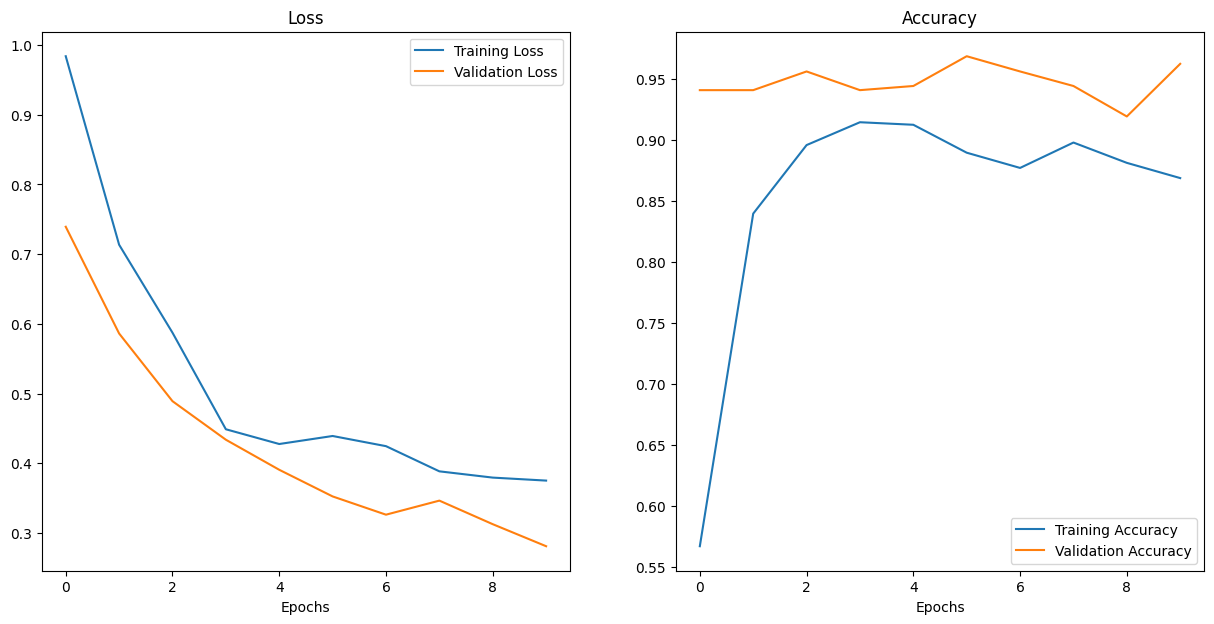

In [15]:
visualization.plot_curves(effnetb2_results)

### Saving model

In [16]:
deployment.save_model_to_directory(model=effnetb2,
                                   target_directory="models",
                                   save_name="pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Model saved to: models/pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


PosixPath('models/pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth')

In [17]:
from pathlib import Path

pretrained_effnetb2_model_size = Path("models/pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024)
print(f"Pretrained EffNetB2 Model size: {pretrained_effnetb2_model_size} MB")

Pretrained EffNetB2 Model size: 29 MB


### Loading & making predictions

In [18]:
effnetb2_model_path = "models/pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"
effnetb2_model = create_effnetb2_model()[0]
effnetb2_model.load_state_dict(torch.load(effnetb2_model_path))

<All keys matched successfully>

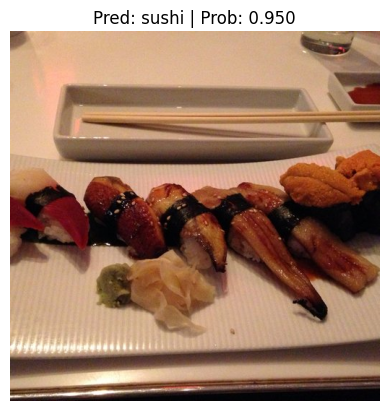

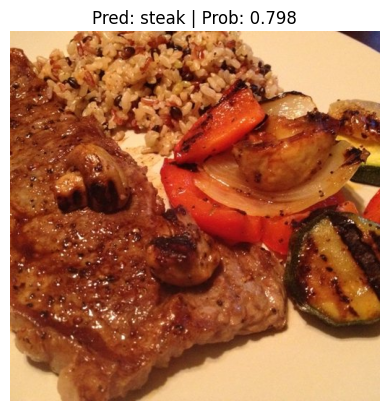

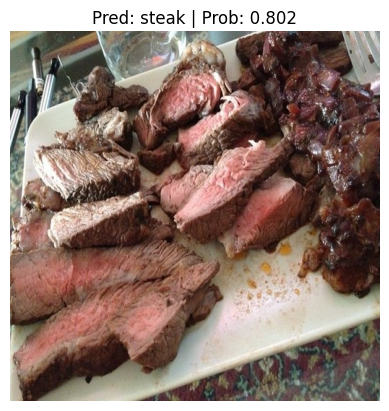

In [19]:
evaluation.pred_and_plot_local_random_images(model=effnetb2_model,
                                              test_dir_path=test_dir,
                                              class_names=class_names,
                                              transform=effnetb2_transforms,
                                              device=device)

### Gradio demo

In [20]:
import gradio as gr
gr.__version__

'3.44.4'

#### Put model to CPU

In [21]:
effnetb2.to("cpu")
next(iter(effnetb2.parameters())).device

device(type='cpu')

#### Creating Predict function

In [22]:
from typing import Tuple, Dict
from timeit import default_timer as timer

def predict(img) -> Tuple[Dict, float]:
    """
    Transforms and performs a prediction on img and returns prediction and time taken.
    """
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class
    # Required format for Gradio's output parameter
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    return pred_labels_and_probs, pred_time

Let's test the function on a random image

In [23]:
import random
from PIL import Image

test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
random_image_path = random.sample(test_data_paths, k=1)[0]

image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

pred_dict, pred_time = predict(img=image)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

[INFO] Predicting on image at path: data/pizza_steak_sushi_20_percent/test/sushi/2352914.jpg

Prediction label and probability dictionary: 
{'pizza': 0.0942283347249031, 'steak': 0.061905231326818466, 'sushi': 0.8438664674758911}
Prediction time: 0.23744 seconds


#### Creating list of examples

In [24]:
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data/pizza_steak_sushi_20_percent/test/pizza/129666.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/399377.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/670345.jpg']]

#### Gradio Interface

In [25]:
import gradio as gr

# Create title, description, & article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor Computer Vision model to classify images of food as pizza, steak or sushi."
article = "Created for my AI/ML portfolio [PaSathees/portfolio](https://github.com/PaSathees/portfolio)."

# Create the Gradio demo
demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                             gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch(debug=False, # print errors locally?
            share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://df88fa7e93e3cd2b36.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


#### Making deployable app

We are going to create this folder structure for us to deploy FoodVision Mini to HuggingFace Spaces

```
demos/
└── foodvision_mini/
    ├── pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
    ├── app.py
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
```

##### Demo folder

In [26]:
import shutil
from pathlib import Path

foodvision_mini_demo_path = Path("demos/foodvision_mini/")

# Remove already existing files if there any and create new directory
if foodvision_mini_demo_path.exists():
    shutil.rmtree(foodvision_mini_demo_path)
    foodvision_mini_demo_path.mkdir(parents=True,
                                    exist_ok=True)
else:
    foodvision_mini_demo_path.mkdir(parents=True,
                                    exist_ok=True)

# Check
!ls demos/foodvision_mini/

##### Examples

In [27]:
# Create an examples directory
foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

# Collect three random test dataset image paths
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/steak/3173402.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/sushi/1063878.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/sushi/2352914.jpg')]

# Copy random images to the examples directory
for example in foodvision_mini_examples:
    destination = foodvision_mini_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/3173402.jpg to demos/foodvision_mini/examples/3173402.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/1063878.jpg to demos/foodvision_mini/examples/1063878.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/2352914.jpg to demos/foodvision_mini/examples/2352914.jpg


Lets check the examples

In [28]:
!ls demos/foodvision_mini/examples

1063878.jpg  2352914.jpg  3173402.jpg


##### Moving model

In [29]:
effnetb2_foodvision_mini_model_path = "models/pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"

effnetb2_foodvision_mini_model_destination = foodvision_mini_demo_path / effnetb2_foodvision_mini_model_path.split("/")[1]

try:
    print(f"[INFO] Attempting to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}")

    # Move the model
    shutil.move(src=effnetb2_foodvision_mini_model_path,
                dst=effnetb2_foodvision_mini_model_destination)

    print(f"[INFO] Model move complete.")

# If the model has already been moved
except:
    print(f"[INFO] No model found at {effnetb2_foodvision_mini_model_path}")
    print(f"[INFO] Model exists at {effnetb2_foodvision_mini_model_destination}: {effnetb2_foodvision_mini_model_destination.exists()}")

[INFO] Attempting to move models/pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth to demos/foodvision_mini/pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
[INFO] Model move complete.


##### model.py

In [30]:
%%writefile demos/foodvision_mini/model.py
import torch
import torchvision

from torch import nn

def create_effnetb2_model(num_classes:int=3, seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    for param in model.parameters():
        param.requires_grad = False

    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

Writing demos/foodvision_mini/model.py


##### app.py

In [31]:
%%writefile demos/foodvision_mini/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ["pizza", "steak", "sushi"]

### 2. Model and transforms preparation ###
# Create EffNetB2 model
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=len(class_names)
)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth",
        map_location=torch.device("cpu"),
    )
)

### 3. Predict function ###
def predict(img) -> Tuple[Dict, float]:
    """
    Transforms and performs a prediction on img and returns prediction and time taken.
    """
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class
    # Required format for Gradio's output parameter
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    return pred_labels_and_probs, pred_time

### 4. Gradio app ###
# Create title, description, & article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor Computer Vision model to classify images of food as pizza, steak or sushi."
article = "Created for my AI/ML portfolio [PaSathees/portfolio](https://github.com/PaSathees/portfolio)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                             gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

Writing demos/foodvision_mini/app.py


##### requirements.txt

In [32]:
print(torch.__version__)
print(torchvision.__version__)
print(gr.__version__)

2.0.1+cu118
0.15.2+cu118
3.44.4


In [33]:
%%writefile demos/foodvision_mini/requirements.txt
torch==2.0.1
torchvision==0.15.2
gradio==3.44.4

Writing demos/foodvision_mini/requirements.txt


#### Deploying to HuggingFace Spaces

Compressing and downloading deployment files

In [34]:
!ls demos/foodvision_mini

app.py
examples
model.py
pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
requirements.txt


In [48]:
# zip the foodvision_mini folder
!cd demos/foodvision_mini && zip -r ../foodvision_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped FoodVision Mini app
try:
    from google.colab import files
    files.download("demos/foodvision_mini.zip")
except:
    print("Not running in Google Colab, please manually download.")

updating: app.py (deflated 55%)
updating: examples/ (stored 0%)
updating: examples/1063878.jpg (deflated 1%)
updating: examples/2352914.jpg (deflated 0%)
updating: examples/3173402.jpg (deflated 1%)
updating: model.py (deflated 54%)
updating: pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth (deflated 8%)
updating: requirements.txt (deflated 4%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Deployment steps:
1. Create HuggingFace Spaces
2. Testing locally
- Unzip deployment files
- Changing into the `foodvision_mini`: `cd foodvision_mini`
- Creating an environment: `python3 -m venv env`
- Activating the environment: `source env/bin/activate`
- Installing the requirements: `pip install -r requirements.txt`
   * **Note:** If any errors: `pip install --upgrade pip`.
- Run the app: `python3 app.py`
3. Clone repo locally: `git clone https://huggingface.co/spaces/[YOUR_USERNAME]/[YOUR_SPACE_NAME]`
4. Install [Git LFS](https://git-lfs.com/)
5. Activate Git LFS: `git lfs install`
6. Track with LFS: `git lfs track "pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"`
7. Track `.gitattributes`: `git add .gitattributes`
8. Add and track rest of the files: `git add *`, `git commit -m "first commit"`
9. Push: `git push`

#### Embedding deployed app

In [35]:
from IPython.display import IFrame

IFrame(src="https://hf.space/embed/PaSathees/FoodVision_Mini/+", width=900, height=750)

## 2.B FoodVision Big

### Getting EfficientNet_B2 pretrained model

In [11]:
def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    for param in model.parameters():
        param.requires_grad = False

    utils.set_seeds(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

In [12]:
effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101, seed=42)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 81.5MB/s]


In [13]:
# summary(effnetb2_food101,
#         input_size=(1, 3, 224, 224),
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

### Getting Food101 20% dataset

In [14]:
food101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms,
])

In [15]:
from torchvision import datasets
from pathlib import Path

data_dir = Path("data")

train_data = datasets.Food101(root=data_dir,
                              split="train",
                              transform=food101_train_transforms,
                              download=True)

test_data = datasets.Food101(root=data_dir,
                             split="test",
                             transform=effnetb2_transforms,
                             download=True)

100%|██████████| 4996278331/4996278331 [04:31<00:00, 18389409.58it/s]


Extracting data/food-101.tar.gz to data


In [16]:
food101_class_names = train_data.classes
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

Creating custom percent of the original images (10%, 20%)

In [17]:
def split_dataset(dataset:torchvision.datasets, split_size:float=0.2, seed:int=42):
    """
    Randomly splits a given dataset into two proportions based on split_size and seed.

    Args:
        dataset (torchvision.datasets): A PyTorch Dataset, typically one from torchvision.datasets.
        split_size (float, optional): How much of the dataset should be split?
            E.g. split_size=0.2 means there will be a 20% split and an 80% split. Defaults to 0.2.
        seed (int, optional): Seed for random generator. Defaults to 42.

    Returns:
        tuple: (random_split_1, random_split_2) where random_split_1 is of size split_size*len(dataset) and
            random_split_2 is of size (1-split_size)*len(dataset).
    """
    length_1 = int(len(dataset) * split_size)
    length_2 = len(dataset) - length_1

    print(f"[INFO] Splitting dataset of length {len(dataset)} into splits of size: {length_1} ({int(split_size*100)}%), {length_2} ({int((1-split_size)*100)}%)")

    random_split_1, random_split_2 = torch.utils.data.random_split(dataset,
                                                                   lengths=[length_1, length_2],
                                                                   generator=torch.manual_seed(seed))
    return random_split_1, random_split_2

In [18]:
# Training 20% split of Food101
train_data_food101_20_percent, _ = split_dataset(dataset=train_data,
                                                 split_size=0.2)

# Testing 20% split of Food101
test_data_food101_20_percent, _ = split_dataset(dataset=test_data,
                                                split_size=0.2)

len(train_data_food101_20_percent), len(test_data_food101_20_percent)

[INFO] Splitting dataset of length 75750 into splits of size: 15150 (20%), 60600 (80%)
[INFO] Splitting dataset of length 25250 into splits of size: 5050 (20%), 20200 (80%)


(15150, 5050)

### Creating dataloaders

In [19]:
import os
import torch

BATCH_SIZE = 32
NUM_WORKERS = 2 if os.cpu_count() <= 4 else 4

# Food101 20 percent training DataLoader
train_dataloader_food101_20_percent = torch.utils.data.DataLoader(train_data_food101_20_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=True,
                                                                  num_workers=NUM_WORKERS)
# Food101 20 percent testing DataLoader
test_dataloader_food101_20_percent = torch.utils.data.DataLoader(test_data_food101_20_percent,
                                                                 batch_size=BATCH_SIZE,
                                                                 shuffle=False,
                                                                 num_workers=NUM_WORKERS)

### Training model

In [22]:
optimizer = torch.optim.Adam(params=effnetb2_food101.parameters(),
                             lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

utils.set_seeds()
effnetb2_food101_results = engine.train(model=effnetb2_food101.to(device),
                                train_dataloader=train_dataloader_food101_20_percent,
                                val_dataloader=test_dataloader_food101_20_percent,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

[INFO] Using device: cuda


  0%|          | 0/10 [00:00<?, ?it/s]

[INFO] Epoch: 1 | Train_loss: 3.3916 | Train_acc: 0.3489 | Val_loss: 2.7111 | Val_acc: 0.4917
[INFO] Epoch: 2 | Train_loss: 2.8285 | Train_acc: 0.4439 | Val_loss: 2.4531 | Val_acc: 0.5367
[INFO] Epoch: 3 | Train_loss: 2.6438 | Train_acc: 0.4891 | Val_loss: 2.3554 | Val_acc: 0.5566
[INFO] Epoch: 4 | Train_loss: 2.5388 | Train_acc: 0.5113 | Val_loss: 2.2988 | Val_acc: 0.5751
[INFO] Epoch: 5 | Train_loss: 2.4937 | Train_acc: 0.5239 | Val_loss: 2.2790 | Val_acc: 0.5800
[INFO] Epoch: 6 | Train_loss: 2.4322 | Train_acc: 0.5397 | Val_loss: 2.2661 | Val_acc: 0.5808
[INFO] Epoch: 7 | Train_loss: 2.4098 | Train_acc: 0.5443 | Val_loss: 2.2358 | Val_acc: 0.5927
[INFO] Epoch: 8 | Train_loss: 2.3873 | Train_acc: 0.5475 | Val_loss: 2.2391 | Val_acc: 0.5924
[INFO] Epoch: 9 | Train_loss: 2.3672 | Train_acc: 0.5595 | Val_loss: 2.2204 | Val_acc: 0.5978
[INFO] Epoch: 10 | Train_loss: 2.3454 | Train_acc: 0.5612 | Val_loss: 2.2252 | Val_acc: 0.5971
[INFO] Training time: 2194.928 seconds


### Plotting loss curves

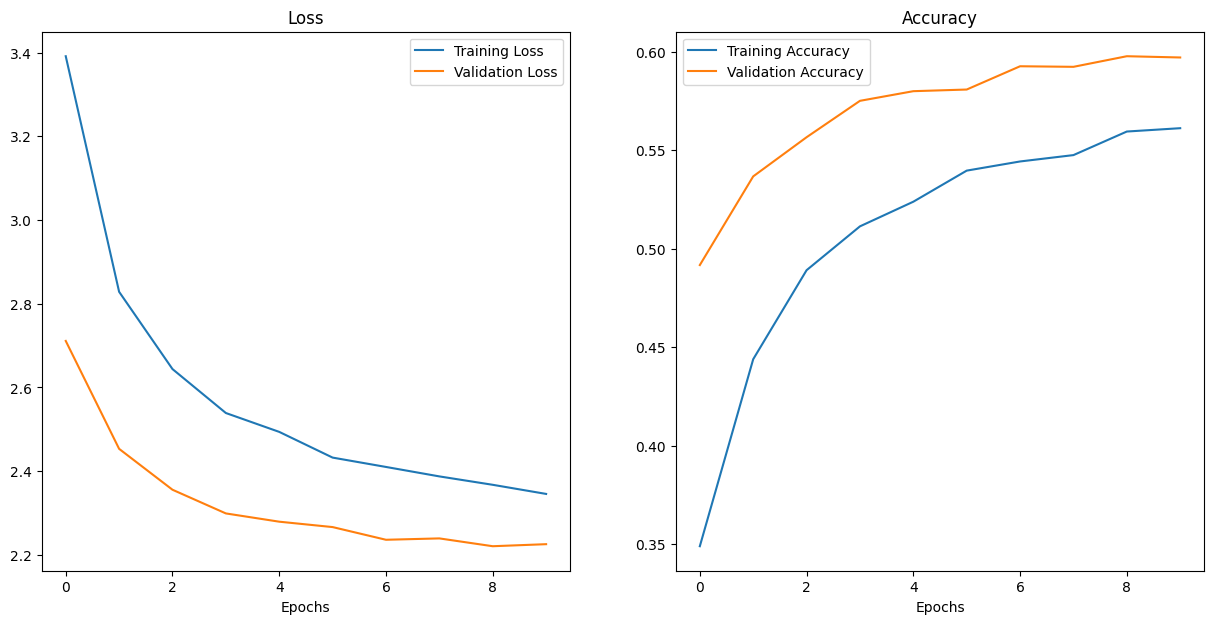

In [23]:
visualization.plot_curves(effnetb2_food101_results)

### Saving model

In [24]:
deployment.save_model_to_directory(model=effnetb2_food101,
                                   target_directory="models",
                                   save_name="pretrained_effnetb2_feature_extractor_food101_20_percent.pth")

[INFO] Model saved to: models/pretrained_effnetb2_feature_extractor_food101_20_percent.pth


PosixPath('models/pretrained_effnetb2_feature_extractor_food101_20_percent.pth')

In [25]:
from pathlib import Path

pretrained_effnetb2_food101_model_size = Path("models/pretrained_effnetb2_feature_extractor_food101_20_percent.pth").stat().st_size // (1024*1024)
print(f"Pretrained Effnet_B2 Model size: {pretrained_effnetb2_food101_model_size} MB")

Pretrained Effnet_B2 Model size: 30 MB


### Loading & making predictions

In [26]:
effnetb2_model_path = "models/pretrained_effnetb2_feature_extractor_food101_20_percent.pth"
effnetb2_model = create_effnetb2_model(num_classes=101)[0]
effnetb2_model.load_state_dict(torch.load(effnetb2_model_path))

<All keys matched successfully>

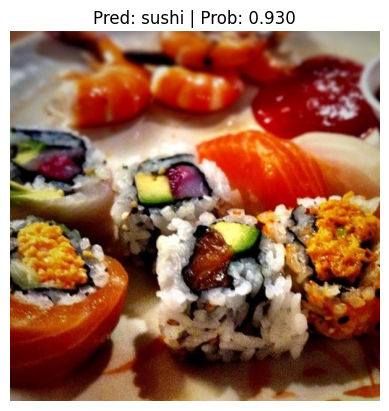

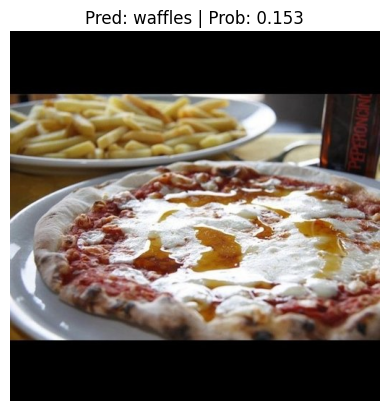

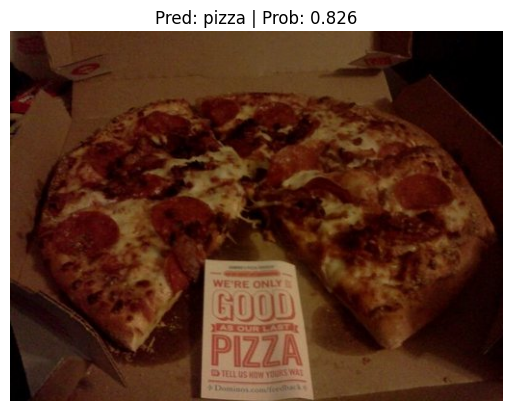

In [28]:
evaluation.pred_and_plot_local_random_images(model=effnetb2_model,
                                              test_dir_path=test_dir,
                                              class_names=food101_class_names,
                                              transform=effnetb2_transforms,
                                              device=device)

### Gradio demo

In [29]:
import gradio as gr
gr.__version__

'3.44.4'

#### Put model to CPU

In [31]:
effnetb2_model.to("cpu")
next(iter(effnetb2_model.parameters())).device

device(type='cpu')

#### Creating Predict function

In [36]:
from typing import Tuple, Dict
from timeit import default_timer as timer

def predict(img) -> Tuple[Dict, float]:
    """
    Transforms and performs a prediction on img and returns prediction and time taken.
    """
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2_model.eval()
    with torch.inference_mode():
        pred_probs = torch.softmax(effnetb2_model(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class
    # Required format for Gradio's output parameter
    pred_labels_and_probs = {food101_class_names[i]: float(pred_probs[0][i]) for i in range(len(food101_class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    return pred_labels_and_probs, pred_time

Let's test the function on a random image

In [37]:
import random
from PIL import Image

test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
random_image_path = random.sample(test_data_paths, k=1)[0]

image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

pred_dict, pred_time = predict(img=image)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

[INFO] Predicting on image at path: data/pizza_steak_sushi_20_percent/test/pizza/441659.jpg

Prediction label and probability dictionary: 
{'apple_pie': 0.00039862890844233334, 'baby_back_ribs': 0.0004800609312951565, 'baklava': 3.67802131222561e-05, 'beef_carpaccio': 0.001474384218454361, 'beef_tartare': 0.00010598505468806252, 'beet_salad': 0.001039920374751091, 'beignets': 0.00048219217569567263, 'bibimbap': 0.005310943350195885, 'bread_pudding': 0.00024636133457534015, 'breakfast_burrito': 0.031214183196425438, 'bruschetta': 0.015221912413835526, 'caesar_salad': 0.0018413851503282785, 'cannoli': 0.0007176870130933821, 'caprese_salad': 0.0051811165176332, 'carrot_cake': 0.0004175155481789261, 'ceviche': 0.23304978013038635, 'cheese_plate': 8.627044735476375e-05, 'cheesecake': 0.00014801096403971314, 'chicken_curry': 0.006024775095283985, 'chicken_quesadilla': 0.0021037471015006304, 'chicken_wings': 0.00016951530415099114, 'chocolate_cake': 0.0006177957402542233, 'chocolate_mousse': 

#### Creating list of examples

In [38]:
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data/pizza_steak_sushi_20_percent/test/pizza/1618659.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/3553838.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/595836.jpg']]

#### Gradio interface

In [39]:
import gradio as gr

# Create title, description, & article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor Computer Vision model to classify images of food as pizza, steak or sushi."
article = "Created for my AI/ML portfolio [PaSathees/portfolio](https://github.com/PaSathees/portfolio)."

# Create the Gradio demo
demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                             gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch!
demo.launch(debug=False,
            share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://18cb24908784da8e74.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


#### Making deployable app

We are going to create this folder structure for us to deploy FoodVision Big to HuggingFace Spaces

```
demos/
└── foodvision_big/
    ├── pretrained_effnetb2_feature_extractor_food101_20_percent.pth
    ├── app.py
    ├── class_names.txt
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
```

##### Demo folder

In [40]:
import shutil
from pathlib import Path

foodvision_big_demo_path = Path("demos/foodvision_big/")

# Remove already existing files if there any and create new directory
if foodvision_big_demo_path.exists():
    shutil.rmtree(foodvision_big_demo_path)
    foodvision_big_demo_path.mkdir(parents=True,
                                    exist_ok=True)
else:
    foodvision_big_demo_path.mkdir(parents=True,
                                    exist_ok=True)

# Check
!ls demos/foodvision_big/

##### Examples

In [41]:
# Create an examples directory
foodvision_big_examples_path = foodvision_big_demo_path / "examples"
foodvision_big_examples_path.mkdir(parents=True, exist_ok=True)

# Collect three random test dataset image paths
foodvision_big_examples = [Path('data/pizza_steak_sushi_20_percent/test/pizza/1618659.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3553838.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/595836.jpg')]

# Copy random images to the examples directory
for example in foodvision_big_examples:
    destination = foodvision_big_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/1618659.jpg to demos/foodvision_big/examples/1618659.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/3553838.jpg to demos/foodvision_big/examples/3553838.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/595836.jpg to demos/foodvision_big/examples/595836.jpg


Lets check the examples

In [43]:
!ls demos/foodvision_big/examples

1618659.jpg  3553838.jpg  595836.jpg


##### Moving model

In [44]:
effnetb2_foodvision_big_model_path = "models/pretrained_effnetb2_feature_extractor_food101_20_percent.pth"

effnetb2_foodvision_big_model_destination = foodvision_big_demo_path / effnetb2_foodvision_big_model_path.split("/")[1]

try:
    print(f"[INFO] Attempting to move {effnetb2_foodvision_big_model_path} to {effnetb2_foodvision_big_model_destination}")

    # Move the model
    shutil.move(src=effnetb2_foodvision_big_model_path,
                dst=effnetb2_foodvision_big_model_destination)

    print(f"[INFO] Model move complete.")

# If the model has already been moved
except:
    print(f"[INFO] No model found at {effnetb2_foodvision_big_model_path}")
    print(f"[INFO] Model exists at {effnetb2_foodvision_big_model_destination}: {effnetb2_foodvision_big_model_destination.exists()}")

[INFO] Attempting to move models/pretrained_effnetb2_feature_extractor_food101_20_percent.pth to demos/foodvision_big/pretrained_effnetb2_feature_extractor_food101_20_percent.pth
[INFO] Model move complete.


##### model.py

In [46]:
%%writefile demos/foodvision_big/model.py
import torch
import torchvision

from torch import nn

def create_effnetb2_model(num_classes:int=3, seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    for param in model.parameters():
        param.requires_grad = False

    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

Writing demos/foodvision_big/model.py


##### class_names.txt

In [47]:
foodvision_big_class_names_path = foodvision_big_demo_path / "class_names.txt"

with open(foodvision_big_class_names_path, "w") as f:
    print(f"[INFO] Saving Food101 class names to {foodvision_big_class_names_path}")
    f.write("\n".join(food101_class_names))

[INFO] Saving Food101 class names to demos/foodvision_big/class_names.txt


Testing saved class names

In [48]:
with open(foodvision_big_class_names_path, "r") as f:
    food101_class_names_loaded = [food.strip() for food in  f.readlines()]

food101_class_names_loaded[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

##### app.py

In [49]:
%%writefile demos/foodvision_big/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
with open("class_names.txt", "r") as f:
    class_names = [food_name.strip() for food_name in  f.readlines()]

### 2. Model and transforms preparation ###
# Create EffNetB2 model
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=len(class_names)
)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="pretrained_effnetb2_feature_extractor_food101_20_percent.pth",
        map_location=torch.device("cpu"),
    )
)

### 3. Predict function ###
def predict(img) -> Tuple[Dict, float]:
    """
    Transforms and performs a prediction on img and returns prediction and time taken.
    """
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class
    # Required format for Gradio's output parameter
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    return pred_labels_and_probs, pred_time

### 4. Gradio app ###
# Create title, description, & article strings
title = "FoodVision Big 🍔👁🍕🥩🍣"
description = "An EfficientNetB2 feature extractor Computer Vision model to classify images of food as 101 types of foods [Food101](https://pytorch.org/vision/main/generated/torchvision.datasets.Food101.html)."
article = "Created for my AI/ML portfolio [PaSathees/portfolio](https://github.com/PaSathees/portfolio)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=5, label="Predictions"),
                             gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

Writing demos/foodvision_big/app.py


##### requirements.txt

In [50]:
print(torch.__version__)
print(torchvision.__version__)
print(gr.__version__)

2.0.1+cu118
0.15.2+cu118
3.44.4


In [52]:
%%writefile demos/foodvision_big/requirements.txt
torch==2.0.1
torchvision==0.15.2
gradio==3.44.4

Writing demos/foodvision_big/requirements.txt


#### Deploying to HuggingFace Spaces

In [53]:
!ls demos/foodvision_big

app.py		 model.py
class_names.txt  pretrained_effnetb2_feature_extractor_food101_20_percent.pth
examples	 requirements.txt


In [54]:
# zip the foodvision_big folder
!cd demos/foodvision_big && zip -r ../foodvision_big.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped FoodVision Big app
try:
    from google.colab import files
    files.download("demos/foodvision_big.zip")
except:
    print("Not running in Google Colab, please manually download.")

  adding: app.py (deflated 55%)
  adding: class_names.txt (deflated 48%)
  adding: examples/ (stored 0%)
  adding: examples/1618659.jpg (deflated 1%)
  adding: examples/3553838.jpg (deflated 0%)
  adding: examples/595836.jpg (deflated 1%)
  adding: model.py (deflated 54%)
  adding: pretrained_effnetb2_feature_extractor_food101_20_percent.pth (deflated 8%)
  adding: requirements.txt (deflated 4%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Deployment steps:
1. Create HuggingFace Spaces
2. Testing locally
- Unzip deployment files
- Changing into the `foodvision_big`: `cd foodvision_big`
- Creating an environment: `python3 -m venv env`
- Activating the environment: `source env/bin/activate`
- Installing the requirements: `pip install -r requirements.txt`
   * **Note:** If any errors: `pip install --upgrade pip`.
- Run the app: `python3 app.py`
3. Clone repo locally: `git clone https://huggingface.co/spaces/[YOUR_USERNAME]/[YOUR_SPACE_NAME]`
4. Install [Git LFS](https://git-lfs.com/)
5. Activate Git LFS: `git lfs install`
6. Track with LFS: `git lfs track "pretrained_effnetb2_feature_extractor_food101_20_percent.pth"`
7. Track `.gitattributes`: `git add .gitattributes`
8. Add and track rest of the files: `git add *`, `git commit -m "first commit"`
9. Push: `git push`

#### Embedding deployed app

In [55]:
from IPython.display import IFrame

IFrame(src="https://hf.space/embed/PaSathees/FoodVision_Big/+", width=900, height=750)

In [56]:
print("Happy building & deploying models, end of notebook")

Happy building & deploying models, end of notebook
